In [224]:
import os
import glob
import math
import pickle
import random
import datetime
from collections import defaultdict
import copy
from enum import Enum
import numpy as np 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
import tqdm
import gymnasium as gym
from gym import Env

from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from gym.utils.env_checker import check_env
from typing import (
    Type,
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
import stable_baselines3
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.env_checker import check_env
from torch.utils.tensorboard import SummaryWriter


In [225]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

2.1.0
0.28.1



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [226]:
import math
N = 100
lower_bound = -5
upper_bound = 5

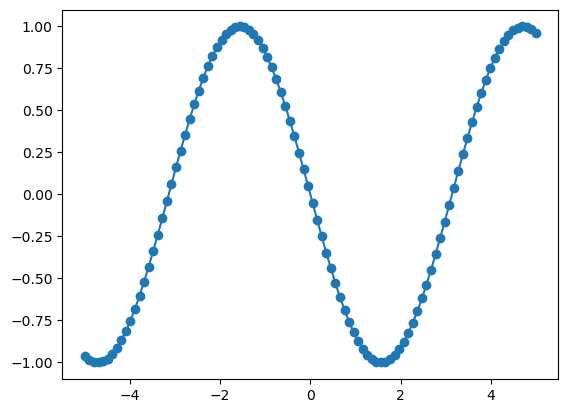

In [227]:
plt.plot(np.linspace(upper_bound, lower_bound, N), np.sin(np.linspace(lower_bound, upper_bound, N)), marker='o')

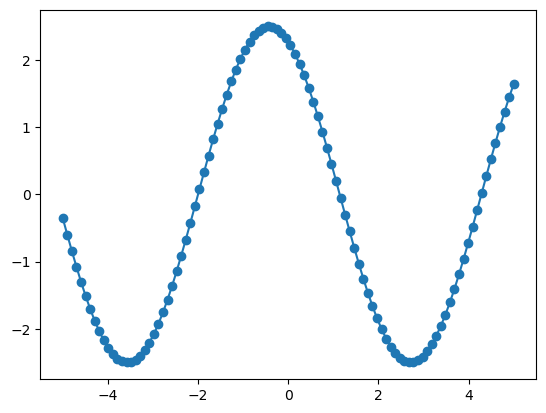

In [228]:
amp = 2.5
phase_shift = 2
plt.plot(np.linspace(lower_bound, upper_bound, N), amp*np.sin([x + phase_shift for x in np.linspace(lower_bound, upper_bound, N)]), marker='o')
# increasing amplitude to 2.5 with phase shift 2

In [229]:
x_np = np.linspace(lower_bound, upper_bound, N) 
x = torch.from_numpy(x_np)
print(x.dtype)

torch.float64


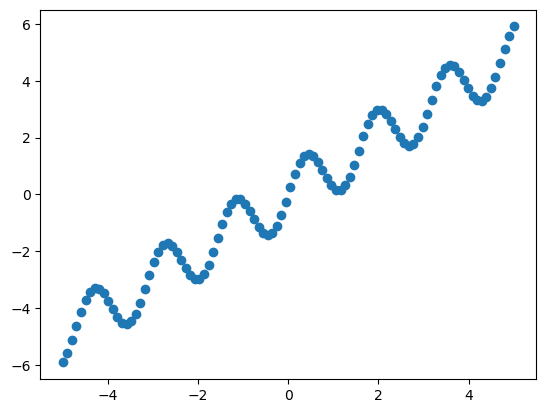

In [230]:
sine_wave = x + np.sin(4*x)
plt.plot(x, sine_wave, 'o');

## config

In [282]:
config = {
    'SEED' : 41,
    'DEVICE' : 'cuda',
    'EPOCHS' : 20,
    'TIMESTEPS' : 10000,
    'N_X' : 100,
    'N_TASKS' : 10,
    'POOL_N_LAYERS' : 100,
    'N_NODES_PER_LAYER' : 32,
    'POOL_LAYER_TYPE' : torch.nn.Linear,
    'ACTION_SPACE_SHAPE' : (3,),
    'EPSILON' : 0.1,
    'BATCH_SIZE' : 1,
    'LEARNING_RATE' : 0.01,
    'ACTION_CACHE_SIZE' : 5,
    'NUM_WORKERS' : 0,
    'LOSS_FN' : torch.nn.MSELoss(),
    'SB3_MODEL' : PPO,
    'SB3_POLICY' : 'MlpPolicy',
    }
config

{'SEED': 41,
 'DEVICE': 'cuda',
 'EPOCHS': 20,
 'TIMESTEPS': 10000,
 'N_X': 100,
 'N_TASKS': 10,
 'POOL_N_LAYERS': 100,
 'N_NODES_PER_LAYER': 32,
 'POOL_LAYER_TYPE': torch.nn.modules.linear.Linear,
 'ACTION_SPACE_SHAPE': (3,),
 'EPSILON': 0.1,
 'BATCH_SIZE': 1,
 'LEARNING_RATE': 0.01,
 'ACTION_CACHE_SIZE': 5,
 'NUM_WORKERS': 0,
 'LOSS_FN': MSELoss(),
 'SB3_MODEL': stable_baselines3.ppo.ppo.PPO,
 'SB3_POLICY': 'MlpPolicy'}

In [283]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Deicision Process"

- layer pool
- inner network -- composed of layers from layer pool
- outer network (meta learner) -- responsible for parameters and hyperparameters of inner network

In [284]:
class Layer:
    def __init__(self, 
                type: Type[torch.nn.Module]=config['POOL_LAYER_TYPE']):
        self.type = type
        self.params = type
        self.used = False
        self.times_used = 0

class LayerPool:
    # pool of uniform Layer objects each with the same type and shape
    def __init__(self, 
                size: int=config['POOL_N_LAYERS'], 
                layer_type: Type[torch.nn.Module]=config['POOL_LAYER_TYPE'],
                num_nodes_per_layer: int=config['N_NODES_PER_LAYER']):
        self.size = size
        self.layer_type = layer_type
        self.num_nodes_per_layer = num_nodes_per_layer

        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated), except for the first and last layers which are unique
        # for each task
        self.layers = {
            i : Layer(
                type=self.layer_type(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)
                )
            for i in range(size)}

        [torch.nn.init.xavier_uniform_(layer.params.weight) for layer in self.layers.values()]
        
    def __str__(self):
        return f"LayerPool(size={self.size}, layer_type={config['POOL_LAYER_TYPE']}, num_nodes_per_layer={config['N_NODES_PER_LAYER']}"



In [293]:
class InnerNetworkAction(Enum):
    DUMMY = 0
    ADD = 1
    TRAIN = 2

In [294]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['N_X'], '[ERROR] Length should be the same as N_X.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info[index]
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data, self.targets}, info={self.info})'

In [295]:
class InnerNetwork(gym.Env, Module):
    def __init__(self, 
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                learning_rate: float=config['LEARNING_RATE'],
                batch_size: int=config['BATCH_SIZE'],
                epsilon: float=config['EPSILON'],
                action_cache_size: float=config['ACTION_CACHE_SIZE'],
                num_workers: int=config['NUM_WORKERS'],
                shuffle: bool=True,
                log_dir: str='runs',
                ):
        super(InnerNetwork, self).__init__()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.layer_pool = layer_pool
        self.task = task
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.initial_layer = torch.nn.Linear(1, self.layer_pool.num_nodes_per_layer) # TODO is to have param with input_shape
        self.final_layer = torch.nn.Linear(self.layer_pool.num_nodes_per_layer, 1) # TODO is to have param with output_shape
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer])
        self.pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=learning_rate)
        self.action_cache_size = action_cache_size
        self.actions_taken = [InnerNetworkAction.DUMMY] * config['ACTION_CACHE_SIZE']

        self.writer = SummaryWriter(log_dir=log_dir)
        self.timestep = 0

        self.state = self.reset()
        state_shape = self.build_state().shape
        self.observation_space = gym.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=state_shape) # TODO is to normalize
        self.action_space = gym.spaces.discrete.Discrete(self.layer_pool.size + 1)


    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)
        action_index = self.epsilon_greedy(action)
        self.update_inner_network(action_index)
        self.forward_inner_network()
        self.tensorboard_log()
        self.timestep += 1
        s_prime = self.build_state()
        reward = self.reward()
        done = truncated = False
        return (
            s_prime,
            reward, 
            done, 
            truncated,
            {}
        )
    
    def epsilon_greedy(self, action: np.int64) -> int:
        if random.random() <= self.epsilon: 
            action_index = random.randint(0, self.action_space.n - 1)
        else: 
            action_index = action
        return action_index
    
    def update_inner_network(self, action_index: int) -> None:
        if (action_index == 0): 
            self.curr['action_type'] = InnerNetworkAction.TRAIN
            self.actions_taken.append(InnerNetworkAction.TRAIN)
        elif (action_index > 0 and action_index < self.layer_pool.size): 
            self.curr['action_type'] = InnerNetworkAction.ADD
            self.pool_indices.append(action_index)
            next_layer = self.layer_pool.layers[action_index].params
            final_layer = self.layers.pop(-1)
            self.layers.append(next_layer)  
            self.layers.append(final_layer) 
            self.actions_taken.append(InnerNetworkAction.ADD)
            self.curr['action_type'] = InnerNetworkAction.ADD

    def next_batch(self, throw_exception=False) -> dict:
        if (throw_exception):
            return next(self.data_iter)
        else: 
            try:
                batch = next(self.data_iter)
                return batch
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                return next(self.data_iter)

    def forward_inner_network(self) -> None: 
        batch = self.next_batch()
        self.curr['x'] = batch['x']
        self.curr['y'] = batch['y'] 
        self.curr['info'] = batch['info']
        if self.curr['action_type'] == InnerNetworkAction.TRAIN:
            self.train() # needs to be called before forward pass for gradient information to be saved
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
        else:
            self.eval()
        # forward pass
        x = self.curr['x']
        for i in range(len(self.layers) - 1): x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
        assert self.curr['latent_space'].dtype == torch.float32
        assert self.curr['y_hat'].dtype == torch.float32
        # update params if training
        if (self.curr['action_type'] == InnerNetworkAction.TRAIN):
            loss = self.curr['loss']
            loss.backward()
            self.opt.step()

    def build_state(self) -> np.ndarray:
        one_hot_network_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i].params in self.layers else 0 
                                   for i in range(len(self.layer_pool.layers))]))
        sequence_network_layers = torch.tensor(np.array([index + 1 for index in self.pool_indices] + [0] * (self.layer_pool.size - len(self.pool_indices))))
        num_add_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.ADD, self.actions_taken)))).unsqueeze(0)
        num_train_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.TRAIN, self.actions_taken)))).unsqueeze(0)
        num_layers = torch.tensor(len(self.layers)).unsqueeze(0)
        h = torch.tensor([action_enum.value for action_enum in self.actions_taken[-self.action_cache_size:]])
        task_info = torch.tensor([float(value) for value in self.curr['info'].values()])
        return torch.concat((
            one_hot_network_layers,
            sequence_network_layers,
            task_info,
            self.curr['x'],
            self.curr['latent_space'],
            self.curr['y'],
            self.curr['y_hat'],
            num_add_actions,
            num_train_actions,
            num_layers,
            h
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        prev_loss = self.prev['loss']
        curr_loss = self.curr['loss']
        delta_loss = prev_loss - curr_loss
        curr_action = self.curr['action_type']
        if (curr_action == InnerNetworkAction.ADD):
            return delta_loss / math.sqrt(len(self.layers))
        if (curr_action == InnerNetworkAction.TRAIN):
            return delta_loss

    def reset(self, seed=None) -> np.ndarray:
        self.forward_inner_network()
        return self.build_state(), None

    def get_layer_index(self, target_weights: torch.nn.Linear) -> int:
        for i, layer in enumerate(self.layers):
            if isinstance(layer, torch.nn.Linear) and \
            torch.all(torch.eq(layer.weight, target_weights.weight)) and \
            torch.all(torch.eq(layer.bias, target_weights.bias)):
                return i
        return -1 
    
    def tensorboard_log(self):
        task_str = str(self.curr['info']['i'].item())
        self.writer.add_scalar(f'loss/timestep_task_{task_str}', self.curr['loss'], global_step=self.timestep) 
        self.writer.add_scalar(f'num_layers/timestep_task_{task_str}', len(self.layers), global_step=self.timestep) 
        if (len(self.pool_indices)!=0):
            self.writer.add_histogram(f'pool_indices/timestep_task_{task_str}', torch.tensor(self.pool_indices).long(), global_step=self.timestep) 
        self.writer.add_histogram(f'action_types/timestep_task{task_str}', torch.tensor([e.value for e in self.actions_taken]).long(), global_step=self.timestep) 


In [296]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['SB3_MODEL'],
        policy=config['SB3_POLICY'],
        epochs: int=config['EPOCHS'],
        timesteps: int=config['TIMESTEPS'],
        device: str=config['DEVICE'],
        overwrite: bool=True,  # TODO is to revisit this param
        intra_update: bool=True, # TODO is to revisit this param
        log_dir: str='runs',
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.model = model
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite 
        self.intra_update = intra_update
        self.log_dir = log_dir

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        # therefore the number of steps is (timesteps)*(n)*(m)
        first_run = True
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch {epoch + 1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task num={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.env = InnerNetwork(task, self.layer_pool, log_dir=self.log_dir)
                if first_run: 
                    model = self.model(self.policy, 
                                       self.env,
                                       n_steps=config['N_X'],
                                       tensorboard_log=self.log_dir,
                                       verbose=1,)
                    first_run = False
                    
                else: 
                    model.set_env(self.env)

                # train meta learner on task
                model.learn(total_timesteps=self.timesteps, 
                            tb_log_name=f'epoch_{epoch}_task_{i}',
                            reset_num_timesteps=True)

                # epoch log
                self.env.writer.add_scalar(f'loss/epoch_{epoch}_task_{i}', self.env.curr['loss'], global_step=epoch) 
                self.env.writer.close()

                # update pool
                for i in range(len(self.env.pool_indices)):
                    pool_index = self.env.pool_indices[i]
                    updated_layer_copy = self.env.layers[i+1]
                    self.layer_pool.layers[pool_index].params = updated_layer_copy
                    self.layer_pool.layers[pool_index].used = True
                    self.layer_pool.layers[pool_index].times_used += 1
    
    def evaluate_inner_network(self):
        self.env.eval()
        y_hats = []
        try:
            # reset data_iter for full dataset 
            self.env.data_loader = DataLoader(self.env.task, batch_size=self.env.batch_size, shuffle=self.env.shuffle, num_workers=self.env.num_workers)
            self.env.data_iter = iter(self.env.data_loader)
            while True:
                batch = self.env.next_batch(throw_exception=True)
                x = batch['x']
                for i in range(len(self.env.layers)-1):
                    x = torch.nn.functional.relu(self.env.layers[i](x))
                x = self.env.layers[-1](x) # do not relu the very last calculation
                y_hats.append(x)
        except StopIteration:
            pass
        return y_hats

### baby example with just 2 epochs
However, 2 epoch is still going through all 20 tasks, generating 20 different networks, using the same 1 meta policy. Also, on each task we loop through the data 1000 times (timesteps / len(X) == 10000 / 100).
<br>
The benefit of more epochs is we get the meta policy to gnerate 20 different networks again for the 20 tasks, having hopefully learned something from the first run.

### sinusoidal curves regression as in 2018 MAML paper

In [297]:
# create tasks
X = np.linspace(lower_bound, upper_bound, config['N_X'])
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['N_TASKS'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['N_TASKS'])).float()

# (20, 100)
tasks_data = torch.tensor([ 
        X
        for _ in range(config['N_TASKS'])
        ]).float()
tasks_targets = torch.tensor([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ]).float()
tasks_info = [
        [{'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
         for _ in X]
        for i, (a, p) in enumerate(zip(amps, phases))
]

In [298]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([10, 100])
torch.float32
torch.Size([10, 100])
torch.float32
10
100


In [299]:
# create tasks
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['N_TASKS'])]
# create pool
pool = LayerPool()
# create REML
log_dir = f'./runs/ppo_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
model = REML(layer_pool=pool, tasks=tasks, log_dir=log_dir)

In [300]:
config

{'SEED': 41,
 'DEVICE': 'cuda',
 'EPOCHS': 20,
 'TIMESTEPS': 10000,
 'N_X': 100,
 'N_TASKS': 10,
 'POOL_N_LAYERS': 100,
 'N_NODES_PER_LAYER': 32,
 'POOL_LAYER_TYPE': torch.nn.modules.linear.Linear,
 'ACTION_SPACE_SHAPE': (3,),
 'EPSILON': 0.1,
 'BATCH_SIZE': 1,
 'LEARNING_RATE': 0.01,
 'ACTION_CACHE_SIZE': 5,
 'NUM_WORKERS': 0,
 'LOSS_FN': MSELoss(),
 'SB3_MODEL': stable_baselines3.ppo.ppo.PPO,
 'SB3_POLICY': 'MlpPolicy'}

In [301]:
# train
model.train()

[INFO] Epoch 1/20
[INFO] Task num=1/10
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\stach\miniconda3\envs\masters-thesis\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(


Logging to ./runs/ppo_2023-10-12_17-09-45\epoch_0_task_0_1


TypeError: float() argument must be a string or a real number, not 'NoneType'

In [313]:
# (2, 20)
yhats = model.yhats_by_epoch_by_task
indices = model.layerindices_by_epoch_by_task
actions = model.actions_taken_by_epoch_by_task

AttributeError: 'REML' object has no attribute 'yhats_by_epoch_by_task'

C:\Users\stach\AppData\Local\Temp\ipykernel_12716\4051386411.py:17: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y.unsqueeze(0), yhat.unsqueeze(0))


NameError: name 'loss_by_epoch_by_task' is not defined

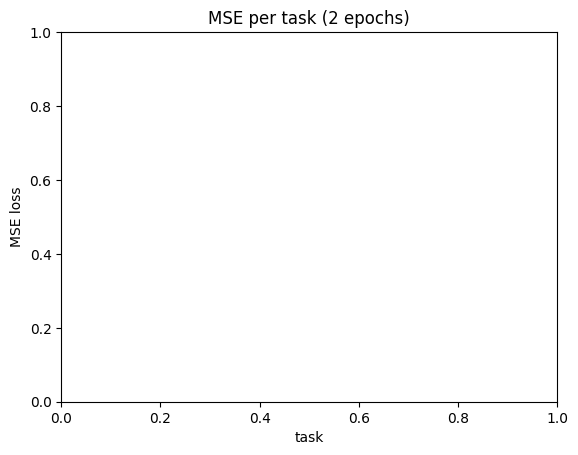

In [20]:
# # yhats
# # x is task
# # y is loss per task averaged over epochs
# plt.xlabel('task')
# plt.ylabel('MSE loss')
# plt.title('MSE per task (2 epochs)')

# # calculate loss values as average for the task for the epoch
# loss_by_task = []
# for (epoch, epoch_dict) in yhats.items(): # 2 epochs
#     epoch_vals = []
#     for task, (key, yhat_values) in zip(tasks, epoch_dict.items()): # 20 tasks
#         # key is task id, which is string of task_info
#         # value is list of yhats or list of tensors
#         losses_by_task = [] 
#         for y, yhat in zip(task.targets, yhat_values):
#             loss = F.mse_loss(y.unsqueeze(0), yhat.unsqueeze(0))
#             loss = loss.detach().numpy()
#             losses_by_task.append(loss)
#         loss_by_task.append(sum(losses_by_task) / len(losses_by_task))
    
# loss_by_epoch_by_task = np.array(loss_by_epoch_by_task)
# print(f'loss_by_epoch_by_task shape={loss_by_epoch_by_task.shape}')

# #         losses = []
# #         for y, y_hat in zip(data[1], y_hats): # 100 values
# #             y_hat = y_hat.unsqueeze(0)
# #             y = torch.tensor(y).unsqueeze(0) # can't iterate over 0d tensors
# #             loss = F.mse_loss(y, y_hat)
# #             losses.append(loss)
# #     loss_by_task.append( (sum(losses)/len(losses)).detach().numpy() ) # can't plot tensor values
# # print(loss_by_task)

# plt.scatter(
#     range(1, config['N_TASKS'] + 1), 
#     loss_by_task
#     )

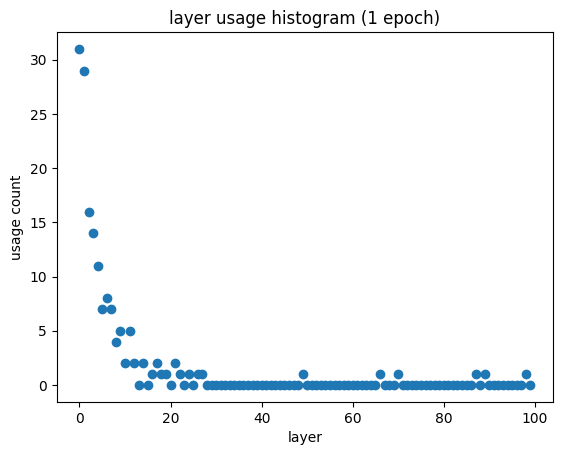

In [568]:
# plot layer use for all tasks
plt.xlabel('layer')
plt.ylabel('usage count')
plt.title('layer usage histogram (1 epoch)')
plt.scatter(
    range(N_X), 
    [layer.times_used for layer in pool.layers.values()]
    );

### Loss w/ transfer vs. w/o transfer

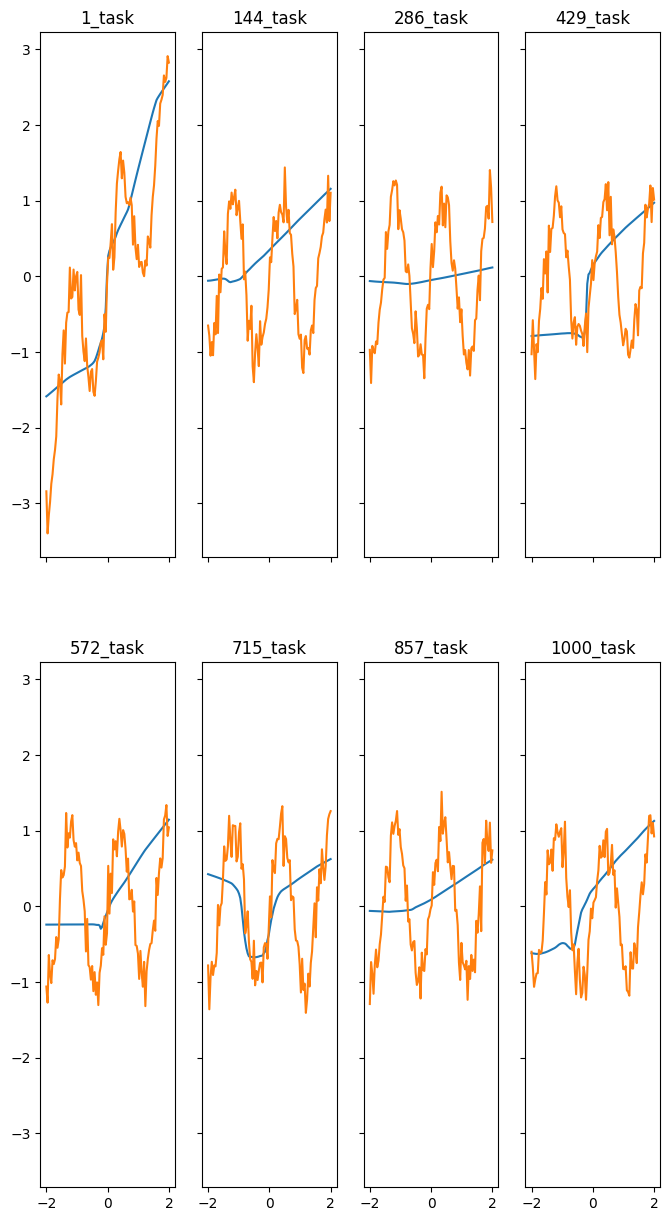

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1